In [5]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev
from astropy.time import Time
%matplotlib inline

In [6]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
import emcee
import triangle

In [54]:
def rv_model(param,xobs,yobs,yerr):
    # ===== Constants
    Ggrav = 6.67428e-11  # m^3/Kg/s^2
    mj = 1.899e27    	 # kg
    me = 5.9736e24    	 # kg
    msun = 1.9891e30     # kg

    # ===== Parameter new names
    jd = xobs
    Vsys    = param[0]
    period  = param[1]
    T0      = param[2] 
    K       = param[3]

    phase  = ((jd-T0) % period) / period
    
    RV = Vsys + K* ( np.cos(2.0*np.pi*phase + np.pi/2.0) )
    
    return RV


[ 3.79347981  5.25762628  0.10962337 -0.99752714  4.77807834 -3.41475581
  5.21745636  5.13242128  2.81987667 -2.14050429 -5.42155634 -5.59978491
 -0.03943598  1.35781951 -2.36942234  3.43161362  4.91151488 -1.37952704
  3.07919941 -4.4388352   2.42620993 -4.97218737 -2.87178383 -3.19082692
 -0.0353899  -4.70578723  4.72505269 -1.69557545  3.2803301   0.66204599]


/Users/lillo_box/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


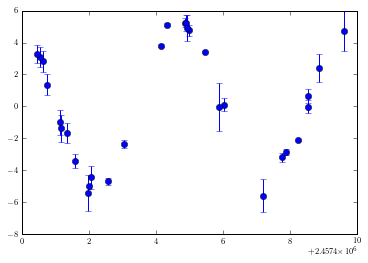

In [77]:
# Generate some data
t = Time('2016-10-27 11:00:00', format='iso', scale='utc')
now = 2457400.0
xobs = np.random.uniform(now, now+10., 30.)
T0     = now+1.0 # JD days
Vsys   = 0.0     # m/s
period = 5.0     # days 
K      = 5.0     # m/s
param = np.array([Vsys, period, T0, K])
yobs = rv_model(param,xobs,xobs,xobs)
yobs += np.random.normal(0.0, size=len(yobs)) * 0.5
yerror = np.random.normal(1.0, size=len(yobs)) * 0.5
plt.errorbar(xobs,yobs,yerr = yerror,fmt ='o')

print yobs

In [78]:
# ===== Define the flat prior
def myprior(min_value, max_value, theta, value,type,name):
    # --- Gaussian prior for the period
    sigma = (max_value+min_value)/2.0
    prob = 1.0/(sigma*np.sqrt(2.0*np.pi)) * np.exp(-(theta-value)**2/(2.0*sigma**2))
    
    
    if type == 'G':
        sigma = (max_value+min_value)/2.0
        prob = 1.0/(sigma*np.sqrt(2.0*np.pi)) * np.exp(-(theta-value)**2/(2.0*sigma**2))
        if name == 'Mstar':
            if theta < 0.0: return 0.0
        if name == 'mp':
            if theta < 0.0: return 0.0
        if name == 'ecc':
            if theta < 0.0: return 0.0
            if theta > 0.999: return 0.99
        return prob
    # --- Flat prior
    if type == 'U':
        if min_value < theta < max_value:
            return 1./(max_value - min_value)
        return 0.0


In [79]:
# ===== Likelihood function [ Ln(likelihood) ]
def lnlike(theta, x, y, yerr):
    model = rv_model(theta, x, y, yerr)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 ))

# ===== Priors for each parameter [ Ln(Prior) ]
def lnprior(theta):

    # --- Gaussian prior for the period
    sigma = 0.23 # days - uncertainty from transit
    value = 4.95 # days - value from transit
    logprior_period = 1.0/(sigma*np.sqrt(2.0*np.pi)) * np.exp(-(theta[1]-value)**2/(2.0*sigma**2))

    # --- Flat prior for the rest    
    # Vsys
    if -5 < theta[0] < 5:
        logprior_Vsys = 1./(10.0)
    else:
        logprior_Vsys = 0.0
    # T0
    if 2457400.0-3 < theta[2] < 2457400.0+3:
        logprior_T0 = 1./(6.)
    else:
        logprior_T0 = 0.0
    # K
    if 0.0 < theta[3] < 100.:
        logprior_K = 1./(100.)
    else:
        logprior_K = 0.0
    
    return np.log(logprior_Vsys)+ np.log(logprior_period)+ np.log(logprior_T0)+ np.log(logprior_K)


# ===== Probability distribution [ Ln(Prob) = Ln(Prior) + Ln(Likelihood)  ]
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    print '---'
    print lp
    if not np.isfinite(lp):
        return -np.inf
    loglike = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike


In [80]:
ndim = len(param)
nwalkers, nsteps = 10, 2000

pos = np.zeros((nwalkers,ndim))
for ii in range(ndim):
    for jj in range(nwalkers):
        pos[jj][ii] = param[ii]+np.random.normal(0.0)*0.1

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xobs, yobs, yerror))
sampler.run_mcmc(pos, nsteps)




---
-8.15042751716
---
-8.24682045735
---
-8.32526168792
---
-8.14967147417
---
-8.15722297528
---
-8.15436684822
---
-8.19605420002
---
-8.1491305175
---
-8.14938908055
---
-8.15049828939
---
-8.15005947634
---
-8.25220875717
---
-8.21493171335
---
-8.14995131343
---
-8.1796549731
---
-8.19404907296
---
-8.25107293624
---
-8.14998574973
---
-8.15314655087
---
-8.15114462968
---
-8.14928511247
---
-8.31761080913
---
-8.23532214178
---
-8.14941704485
---
-8.15660044377
---
-8.14991243713
---
-8.16279931223
---
-8.1491533672
---
-8.15227905389
---
-8.15236891439
---
-8.15014528883
---
-8.16873903237
---
-8.45875063607
---
-8.14975868156
---
-8.149647101
---
-8.15598552791
---
-8.16320193058
---
-8.15045557588
---
-8.14916511007
---
-8.15437348133
---
-8.14988414269
---
-8.15569613291
---
-8.19845880562
---
-8.15013724155
---
-8.15005003718
---
-8.14952886767
---
-8.16120454344
---
-8.15834656433
---
-8.14941960944
---
-8.15442957554
---
-8.1633734686
---
-8.17950932891
---
-8.17042162105

(array([[  1.22752052e-01,   5.12075728e+00,   2.45740090e+06,
           5.21356659e+00],
        [  1.73043221e-01,   5.12630018e+00,   2.45740089e+06,
           5.21979873e+00],
        [  1.67608670e-01,   5.10200333e+00,   2.45740093e+06,
           5.23782012e+00],
        [  1.72586672e-01,   5.14560560e+00,   2.45740087e+06,
           5.20989244e+00],
        [  1.29670515e-01,   5.12534242e+00,   2.45740090e+06,
           5.23463561e+00],
        [  1.84943556e-01,   5.14505679e+00,   2.45740087e+06,
           5.30651639e+00],
        [  2.07928076e-01,   5.15386038e+00,   2.45740086e+06,
           5.22205090e+00],
        [  1.78233536e-01,   5.13791632e+00,   2.45740088e+06,
           5.23488080e+00],
        [  1.97593236e-01,   5.12799452e+00,   2.45740088e+06,
           5.27585625e+00],
        [  1.76453776e-01,   5.13289037e+00,   2.45740089e+06,
           5.23014008e+00]]),
 array([-61.88199007, -60.50412577, -62.42024602, -61.50629819,
        -61.70257758, -6

In [81]:
    chain = sampler.chain
    samples = sampler.chain[:, 0.5*nsteps:, :].reshape((-1, ndim))
    lnprobs = sampler.lnprobability[:, 0.5*nsteps:].reshape((-1))
    result = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))


/Users/lillo_box/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/Users/lillo_box/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [82]:
finalp = np.zeros(ndim)
elow = np.zeros(ndim)
eupp = np.zeros(ndim)
for i in range(ndim):
    finalp[i] = result[i][0]
    elow[i]   = result[i][1]
    eupp[i]   = result[i][2]


In [83]:
pnames = ['Vsys','period','T0','K']
print '============================='
print 'Results of the EMCEE analysis'
for i in range(ndim):
    print pnames[i],finalp[i]
print '============================='



Results of the EMCEE analysis
Vsys 0.156868348641
period 5.11702743953
T0 2457400.90496
K 5.24819974106


Quantiles:
[(0.16, 0.13124951687820322), (0.5, 0.15686834864086163), (0.84, 0.18127305367995283)]
Quantiles:
[(0.16, 5.0981085538278705), (0.5, 5.1170274395343478), (0.84, 5.137641324973294)]
Quantiles:
[(0.16, 2457400.8831904167), (0.5, 2457400.9049586579), (0.84, 2457400.9241551734)]
Quantiles:
[(0.16, 5.2220908324403705), (0.5, 5.2481997410621686), (0.84, 5.2742847919241136)]


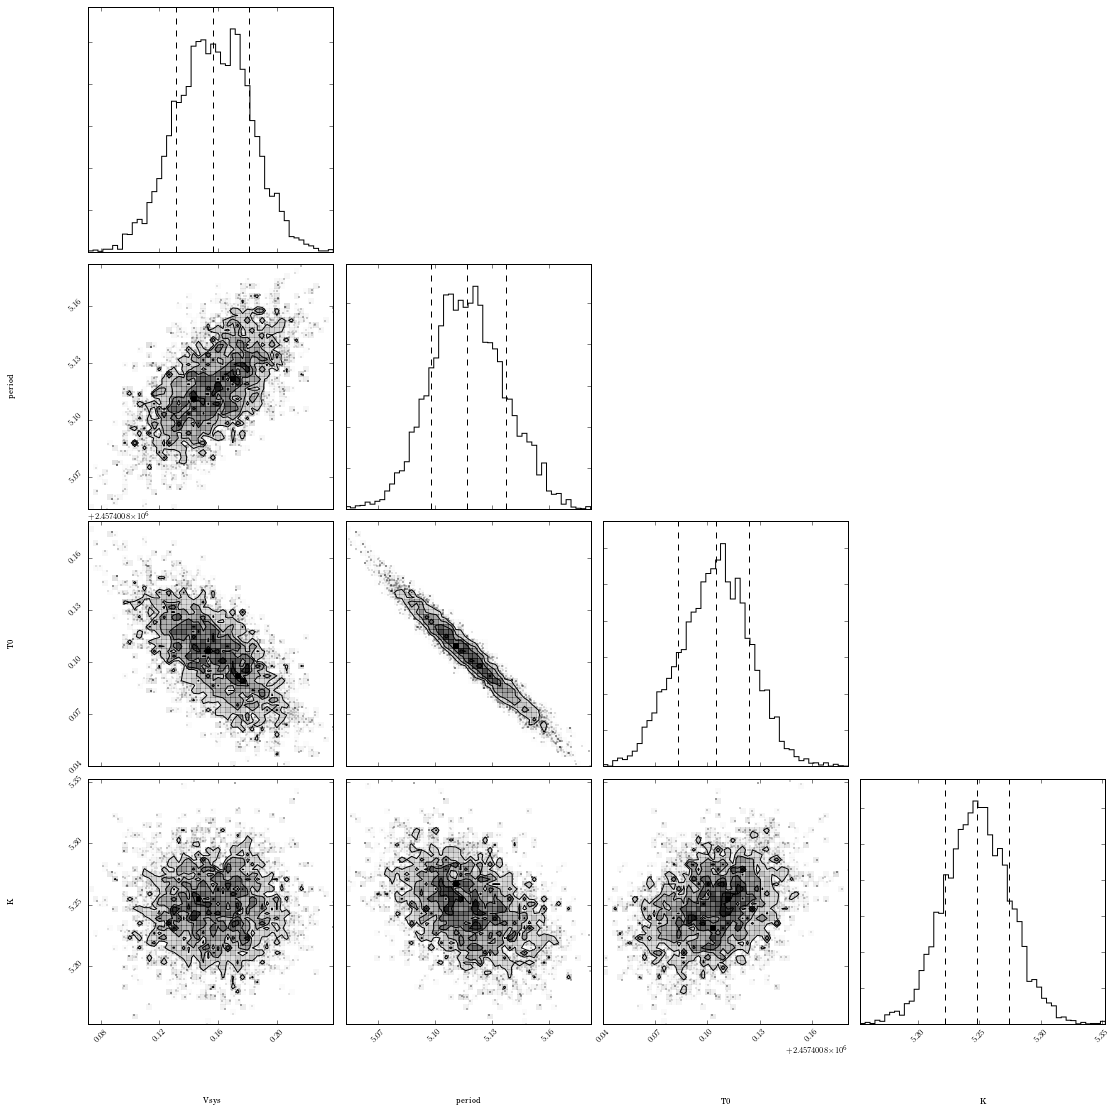

In [84]:
# ===== Corner plot
fig = triangle.corner(samples, labels=pnames,quantiles=[0.16, 0.5, 0.84])   
fig.set_size_inches(16,16)


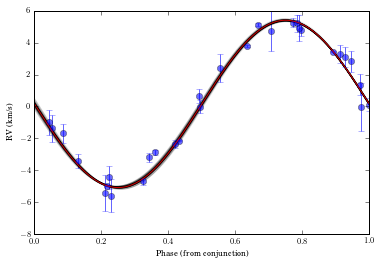

In [87]:
# ===== Result plot in PHASE
fig = plt.figure()
xmodel = np.linspace(0.0,1.0,5000)
period = finalp[1]
T0  = finalp[2]

x = xobs 
y = yobs

burnout=0.5
phase  = ((x-T0) % period) / period + 100.0
xphase  = (phase % 1.0 ) 
for new_param in samples[np.int(len(samples)*burnout)+np.random.randint(len(samples)*burnout, size=100)]:
    ymodel = rv_model(new_param,xmodel*period+T0,xmodel,xmodel)
    plt.plot(xmodel, ymodel, color="k", alpha=0.1)
ymodel = rv_model(finalp,xmodel*period+T0,xmodel,xmodel)
plt.errorbar(xphase, y, yerr=yerror, fmt='o',color='blue',alpha=0.6)
plt.plot(xmodel, ymodel, color="r", lw=1, alpha=0.8)
plt.ylabel('RV (km/s)')
plt.xlabel('Phase (from conjunction)')
